# Calculating SGS Terms
$$\tau_{ij} = \overline{u_iu}_j - \overline{u}_i \overline{u}_j$$ 
$$  \sigma_{i} = \overline{u_i\omega} - \overline{u}_i\overline{\omega}$$
$$\Pi_{\omega} = \nabla \times \Pi_{UV} = \nabla \times \nabla \cdot \tau$$
$$\Pi_{\omega} = \nabla \cdot \sigma $$

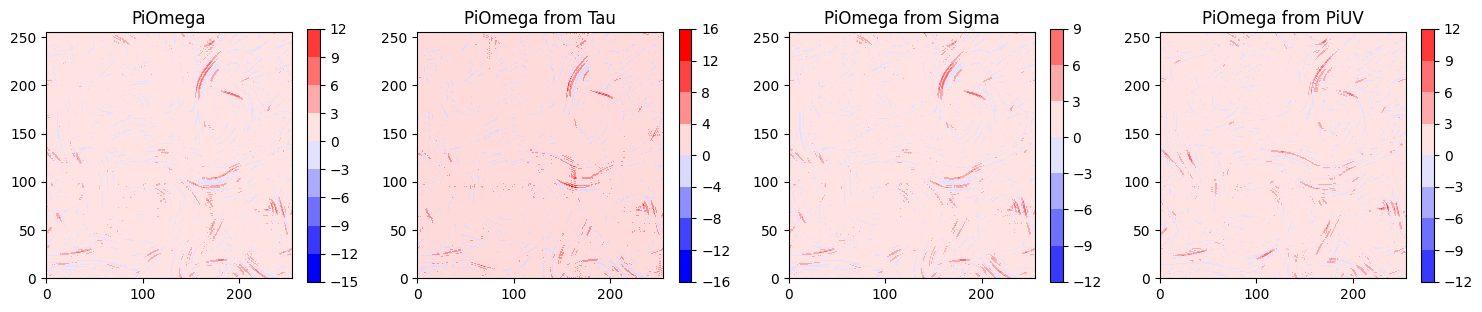

MSE between PiOmega and PiOmega from Tau: 1.6876724602693403
MSE between PiOmega and PiOmega from Sigma: 0.09540177101900041
MSE between PiOmega and PiOmega from PiUV: 5.987746555201147
Correlation coefficient between PiOmega and PiOmega from Tau: 0.6210051242897197
Correlation coefficient between PiOmega and PiOmega from Sigma: 0.9695475757245435
Correlation coefficient between PiOmega and PiOmega from PiUV: -0.9464057771445649


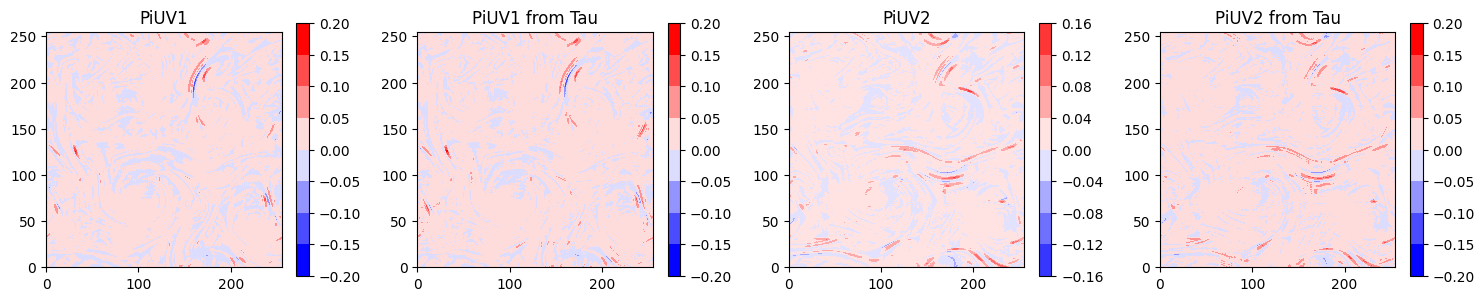

MSE between PiUV1 and PiUV1 from Tau: 5.132649370320983e-05
MSE between PiUV2 and PiUV2 from Tau: 7.908234944333417e-05
Correlation coefficient between PiUV1 and PiUV1 from Tau: 0.8935838372417868
Correlation coefficient between PiUV2 and PiUV2 from Tau: 0.865974815793984


In [1]:
# Import necessary libraries and modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from scipy.io import loadmat

# Importing custom modules 
from py2d.filter import filter2D_2DFHIT
from py2d.SGSterms import Tau, Sigma, PiOmega, PiUV
from py2d.convert import Tau2PiOmega_2DFHIT, Sigma2PiOmega, Tau2PiUV_2DFHIT, PiUV2PiOmega
from py2d.initialize import initialize_wavenumbers_2DFHIT

# Assuming Omega_DNS is provided and is 2D_matrix
# Assuming Kx and Ky are provided

# Define parameters 
nx = 1024
filename = '../data/ICs/NX' + str(nx) + '/1.mat'
Lx = 2 * np.pi
N_LES = 256*np.ones(2, dtype=int)
Delta = 2*Lx/N_LES[0]

filter = 'gaussian'
coarseGrain = 'spectral'

# Load the data from the file
data = loadmat(filename)
# Extract the Omega data from the file
Omega_DNS = data['Omega']

# Initialize wavenumbers
Kx, Ky, Ksq, _, _ = initialize_wavenumbers_2DFHIT(nx, nx, Lx, Lx, INDEXING='ij')

if coarseGrain == 'spectral':
    Kx_coarse, Ky_coarse, Ksq_coarse, _, _ = initialize_wavenumbers_2DFHIT(N_LES[0], N_LES[1], Lx, Lx, INDEXING='ij')
elif coarseGrain == None:
    Kx_coarse, Ky_coarse, Ksq_coarse, _, _ = initialize_wavenumbers_2DFHIT(nx, nx, Lx, Lx, INDEXING='ij')

# Calculate the Tau values
Tau11, Tau12, Tau22 = Tau(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES, dealias=False)

# Calculate the PiUV values
PiUV1, PiUV2 = PiUV(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES)

# Calculate the Sigma values
Sigma1, Sigma2 = Sigma(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES)

# Calculate the PiOmega values
PiOmega = PiOmega(Omega_DNS, filterType=filter, coarseGrainType=coarseGrain, Delta=Delta, N_LES=N_LES)

# Calculate PiUV from Tau
PiUV1_from_Tau, PiUV2_from_Tau = Tau2PiUV_2DFHIT(Tau11=Tau11, Tau12=Tau12, Tau22=Tau22, Kx=Kx_coarse, Ky=Ky_coarse, spectral=False)

# Calculate PiOmega from Tau
PiOmega_from_Tau = Tau2PiOmega_2DFHIT(Tau11=Tau11, Tau12=Tau12, Tau22=Tau22, Kx=Kx_coarse, Ky=Ky_coarse, spectral=False)

# Calculate PiOmega from Sigma
PiOmega_from_Sigma = Sigma2PiOmega(Sigma1=Sigma1, Sigma2=Sigma2, Kx=Kx_coarse, Ky=Ky_coarse, spectral=False)

# Calculate PiOmega from PiUV
PiOmega_from_PiUV = PiUV2PiOmega(PiUV1=PiUV1, PiUV2=PiUV2, Kx=Kx_coarse, Ky=Ky_coarse, spectral=False)

# Find the maximum absolute value across all datasets for symmetric colorbar
vmax = np.max(np.abs([PiOmega, PiOmega_from_Tau, PiOmega_from_Sigma, PiOmega_from_PiUV]))

# Plot contours of all computed values
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
cmaps = ['PiOmega', 'PiOmega from Tau', 'PiOmega from Sigma', 'PiOmega from PiUV']
data = [PiOmega, PiOmega_from_Tau, PiOmega_from_Sigma, PiOmega_from_PiUV]

# Loop through all data to plot
for ax, cmap, dat in zip(axs.flat, cmaps, data):
    contour = ax.contourf(dat, cmap='bwr', vmin=-vmax, vmax=vmax)
    ax.set_title(cmap)
    ax.set_aspect('equal')
    fig.colorbar(contour, ax=ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Calculate mean squared errors for comparison
mse_tau = mean_squared_error(PiOmega, PiOmega_from_Tau)
mse_sigma = mean_squared_error(PiOmega, PiOmega_from_Sigma)
mse_PiUV = mean_squared_error(PiOmega, PiOmega_from_PiUV)

# Display the computed MSE values
print(f"MSE between PiOmega and PiOmega from Tau: {mse_tau}")
print(f"MSE between PiOmega and PiOmega from Sigma: {mse_sigma}")
print(f"MSE between PiOmega and PiOmega from PiUV: {mse_PiUV}")

# Calculate correlation coefficients for comparison
corr_tau, _ = pearsonr(PiOmega.flatten(), PiOmega_from_Tau.flatten())
corr_sigma, _ = pearsonr(PiOmega.flatten(), PiOmega_from_Sigma.flatten())
corr_PiUV, _ = pearsonr(PiOmega.flatten(), PiOmega_from_PiUV.flatten())

# Display the computed correlation coefficients
print(f"Correlation coefficient between PiOmega and PiOmega from Tau: {corr_tau}")
print(f"Correlation coefficient between PiOmega and PiOmega from Sigma: {corr_sigma}")
print(f"Correlation coefficient between PiOmega and PiOmega from PiUV: {corr_PiUV}")

# Find the maximum absolute value across all datasets for symmetric colorbar
vmax = np.max(np.abs([PiUV1, PiUV1_from_Tau, PiUV2, PiUV2_from_Tau]))

# Plot contours of all computed PiUV values
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
cmaps = ['PiUV1', 'PiUV1 from Tau', 'PiUV2', 'PiUV2 from Tau']
data = [PiUV1, PiUV1_from_Tau, PiUV2, PiUV2_from_Tau]

# Loop through all data to plot
for ax, cmap, dat in zip(axs.flat, cmaps, data):
    contour = ax.contourf(dat, cmap='bwr', vmin=-vmax, vmax=vmax)
    ax.set_title(cmap)
    ax.set_aspect('equal')
    fig.colorbar(contour, ax=ax)

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()

# Calculate mean squared errors for comparison
mse_PiUV1 = mean_squared_error(PiUV1, PiUV1_from_Tau)
mse_PiUV2 = mean_squared_error(PiUV2, PiUV2_from_Tau)

# Display the computed MSE values
print(f"MSE between PiUV1 and PiUV1 from Tau: {mse_PiUV1}")
print(f"MSE between PiUV2 and PiUV2 from Tau: {mse_PiUV2}")

# Calculate correlation coefficients for comparison
corr_PiUV1, _ = pearsonr(PiUV1.flatten(), PiUV1_from_Tau.flatten())
corr_PiUV2, _ = pearsonr(PiUV2.flatten(), PiUV2_from_Tau.flatten())

# Display the computed correlation coefficients
print(f"Correlation coefficient between PiUV1 and PiUV1 from Tau: {corr_PiUV1}")
print(f"Correlation coefficient between PiUV2 and PiUV2 from Tau: {corr_PiUV2}")



# Decompostion of the SGS Term - Leonard, Cross Reynolds terms
### This decomposition was proposed by Germano (1986)
$$ \tau_{ij} = L_{ij} + C_{ij} + R_{ij} $$
$$ \sigma_i =  L_i + C_i + R_i$$
$$ \Pi_{\omega} =  L +  C + R $$
\
Following script validates the code to calculate the SGS terms by establishing the above relationship

In [17]:
from py2d.SGSterms import TauLeonard, TauCross, TauReynolds, Tau
from py2d.SGSterms import Sigma, SigmaLeonard, SigmaCross, SigmaReynolds
from py2d.SGSterms import PiOmega, PiOmegaLeonard, PiOmegaCross, PiOmegaReynolds

# Following code tests the accurancy of the SGS decomposition code by ensuring that the sum of Leonard, Cross, and Reynolds is equal to SGS term
print("Testing for accuracy of SGS Decomposition Code. The sum of Leonard, Cross, and Reynolds should be equal to SGS term")
print("MSE ~ 1e-16 and correlation ~ 1.0 indicates that the sum of Leonard, Cross, and Reynolds is equal to SGS term")
print('***************************************************************')

# Initialize filter and coarse grain types for SGS terms calculation
filterType = 'gaussian'
coarseGrainType = 'spectral'
dealias = False

# Loop over different grid sizes to test the accuracy of SGS decomposition
for k in [32, 64, 128, 256]:

    # Calculate the LES grid size and filter width (Delta)
    N_LES = np.array([k, k])
    Delta = 2 * Lx / N_LES[0]  # Assuming Lx is defined elsewhere as the domain size

    # Compute the SGS terms - Tau
    Tau11, Tau12, Tau22 = Tau(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=dealias)
    Tau11Leonard, Tau12Leonard, Tau22Leonard = TauLeonard(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=dealias)
    Tau11Cross, Tau12Cross, Tau22Cross = TauCross(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=dealias)
    Tau11Reynolds, Tau12Reynolds, Tau22Reynolds = TauReynolds(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=dealias)

    # Compute the SGS terms - Sigma
    Sigma1, Sigma2 = Sigma(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=dealias)
    Sigma1Leonard, Sigma2Leonard = SigmaLeonard(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=dealias)
    Sigma1Cross, Sigma2Cross = SigmaCross(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=dealias)
    Sigma1Reynolds, Sigma2Reynolds = SigmaReynolds(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=dealias)

    # Compute the SGS terms - PiOmega
    PiOmega_val = PiOmega(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=dealias)
    PiOmegaLeonard_val = PiOmegaLeonard(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=dealias)
    PiOmegaCross_val = PiOmegaCross(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=dealias)
    PiOmegaReynolds_val = PiOmegaReynolds(Omega_DNS, filterType=filterType, coarseGrainType=coarseGrainType, Delta=Delta, N_LES=N_LES, dealias=dealias)

    # Calculate MSE and correlation 

    # These calculations compare the sum of individual SGS terms to the total Tau term to verify accuracy

    # Tau
    mse_Tau11 = mean_squared_error(Tau11.flatten(), (Tau11Leonard.flatten() + Tau11Cross.flatten() + Tau11Reynolds.flatten()))
    mse_Tau12 = mean_squared_error(Tau12.flatten(), (Tau12Leonard.flatten() + Tau12Cross.flatten() + Tau12Reynolds.flatten()))
    mse_Tau22 = mean_squared_error(Tau22.flatten(), (Tau22Leonard.flatten() + Tau22Cross.flatten() + Tau22Reynolds.flatten()))
    corr_Tau11, _ = pearsonr(Tau11.flatten(), (Tau11Leonard.flatten() + Tau11Cross.flatten() + Tau11Reynolds.flatten()))
    corr_Tau12, _ = pearsonr(Tau12.flatten(), (Tau12Leonard.flatten() + Tau12Cross.flatten() + Tau12Reynolds.flatten()))
    corr_Tau22, _ = pearsonr(Tau22.flatten(), (Tau22Leonard.flatten() + Tau22Cross.flatten() + Tau22Reynolds.flatten()))

    # Sigma
    mse_Sigma1 = mean_squared_error(Sigma1.flatten(), (Sigma1Leonard.flatten() + Sigma1Cross.flatten() + Sigma1Reynolds.flatten()))
    mse_Sigma2 = mean_squared_error(Sigma2.flatten(), (Sigma2Leonard.flatten() + Sigma2Cross.flatten() + Sigma2Reynolds.flatten()))
    corr_Sigma1, _ = pearsonr(Sigma1.flatten(), (Sigma1Leonard.flatten() + Sigma1Cross.flatten() + Sigma1Reynolds.flatten()))
    corr_Sigma2, _ = pearsonr(Sigma2.flatten(), (Sigma2Leonard.flatten() + Sigma2Cross.flatten() + Sigma2Reynolds.flatten()))

    # PiOmega
    mse_PiOmega = mean_squared_error(PiOmega_val.flatten(), (PiOmegaLeonard_val.flatten() + PiOmegaCross_val.flatten() + PiOmegaReynolds_val.flatten()))
    corr_PiOmega, _ = pearsonr(PiOmega_val.flatten(), (PiOmegaLeonard_val.flatten() + PiOmegaCross_val.flatten() + PiOmegaReynolds_val.flatten()))

    # Output the MSE and correlation results for both dealiased and not-dealiased data

    print(f"MSE between Tau and sum of Leonard, Cross, and Reynolds: ", mse_Tau11, mse_Tau12, mse_Tau22)
    print(f"Correlation coefficient between Tau and sum of Leonard, Cross, and Reynolds: ", corr_Tau11, corr_Tau12, corr_Tau22)
    print("###")
    print(f"MSE between Sigma and sum of Leonard, Cross, and Reynolds: ", mse_Sigma1, mse_Sigma2)
    print(f"Correlation coefficient between Sigma and sum of Leonard, Cross, and Reynolds: ", corr_Sigma1, corr_Sigma2)
    print("###")
    print(f"MSE between PiOmega and sum of Leonard, Cross, and Reynolds: ", mse_PiOmega)
    print(f"Correlation coefficient between PiOmega and sum of Leonard, Cross, and Reynolds: ", corr_PiOmega)
    print("########################################################")

Testing for accuracy of SGS Decomposition Code. The sum of Leonard, Cross, and Reynolds should be equal to SGS term
MSE ~ 1e-16 and correlation ~ 1.0 indicates that the sum of Leonard, Cross, and Reynolds is equal to SGS term
***************************************************************
MSE between Tau and sum of Leonard, Cross, and Reynolds:  3.5750320262110824e-31 1.2276280404783894e-31 4.170892101311871e-31
Correlation coefficient between Tau and sum of Leonard, Cross, and Reynolds:  1.0 1.0 1.0
###
MSE between Sigma and sum of Leonard, Cross, and Reynolds:  1.3195411643088458e-30 1.9015138908162603e-30
Correlation coefficient between Sigma and sum of Leonard, Cross, and Reynolds:  1.0 0.9999999999999982
###
MSE between PiOmega and sum of Leonard, Cross, and Reynolds:  2.0412547009272e-28
Correlation coefficient between PiOmega and sum of Leonard, Cross, and Reynolds:  1.0
########################################################
MSE between Tau and sum of Leonard, Cross, and Reyno

Plot the SGS Terms

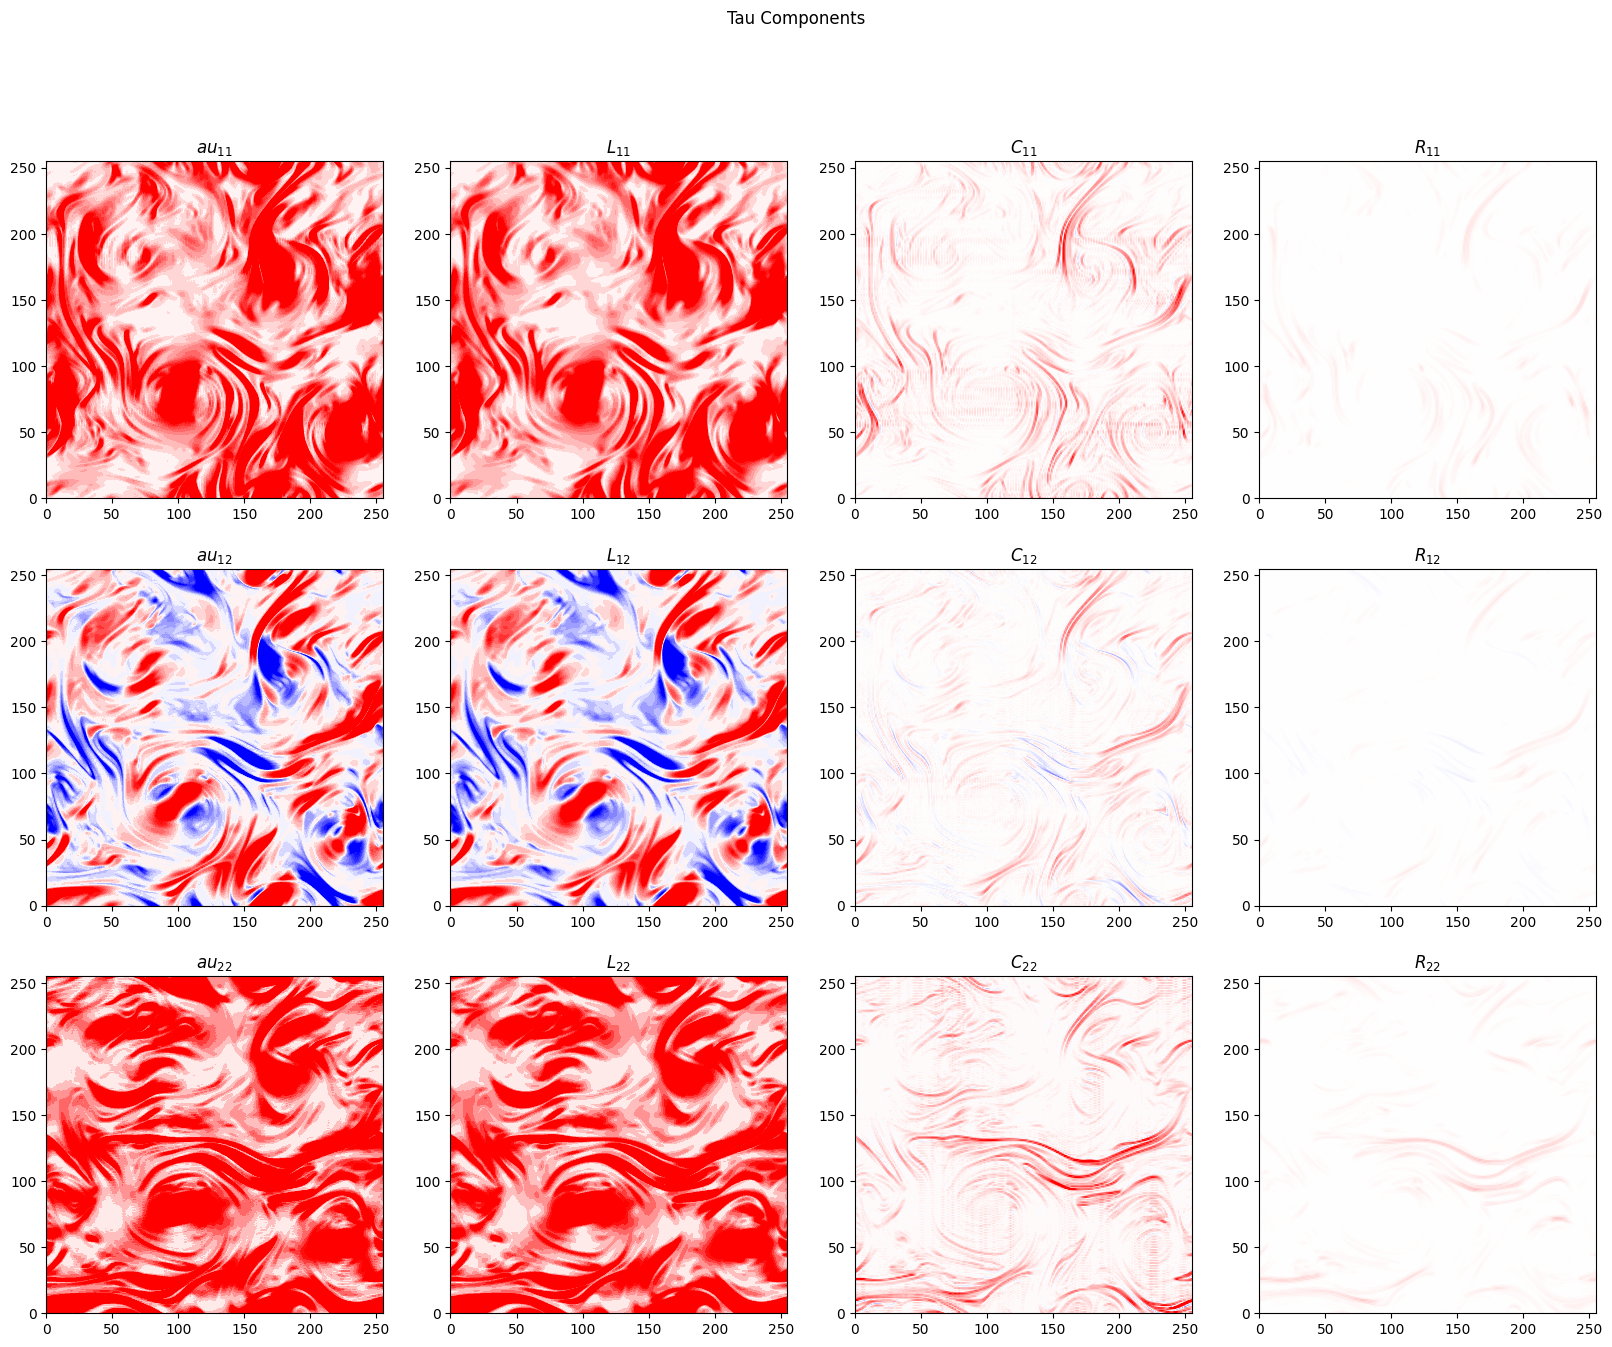

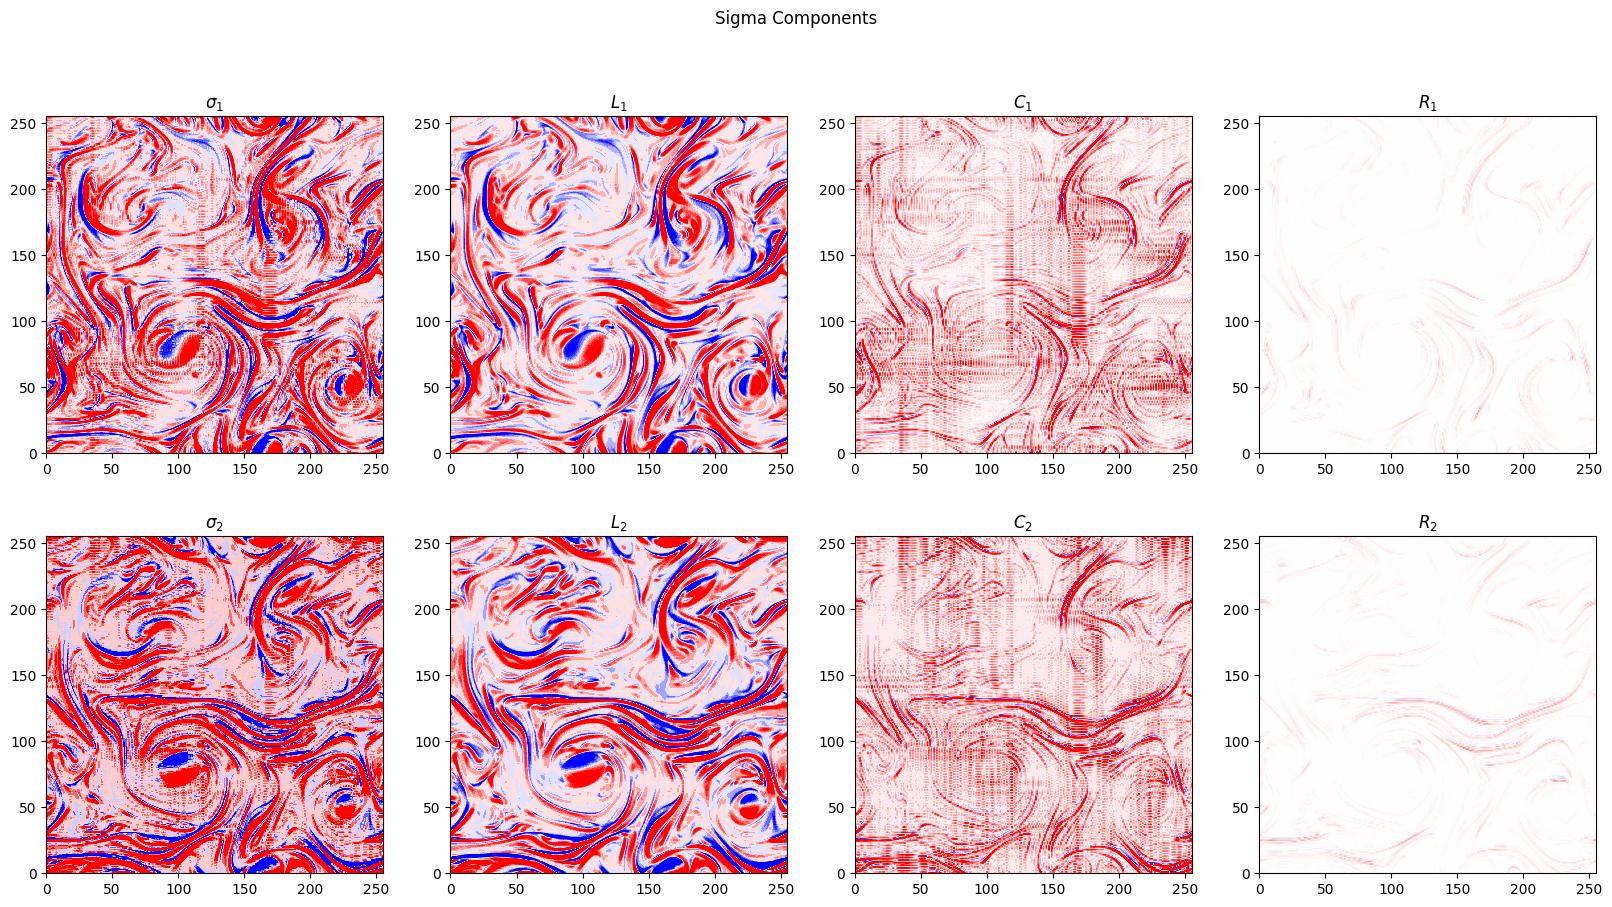

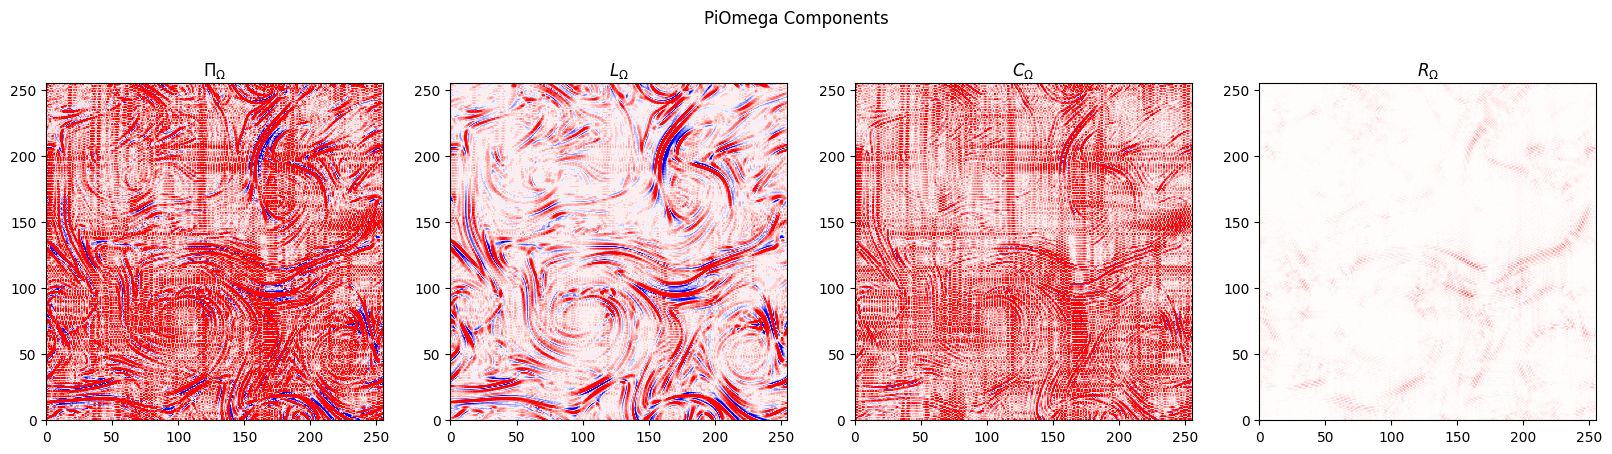

In [18]:
import matplotlib.pyplot as plt
import numpy as np


# Create figure for Tau
plt.figure(figsize=(20, 15))

titles = ['$\tau_{11}$', '$L_{11}$', '$C_{11}$', '$R_{11}$', '$\tau_{12}$', '$L_{12}$', '$C_{12}$', '$R_{12}$', '$\tau_{22}$', '$L_{22}$', '$C_{22}$', '$R_{22}$']
components = [Tau11, Tau11Leonard, Tau11Cross, Tau11Reynolds, Tau12, Tau12Leonard, Tau12Cross, Tau12Reynolds, Tau22, Tau22Leonard, Tau22Cross, Tau22Reynolds]

for i, component in enumerate(components):
    ax = plt.subplot(3, 4, i+1)
    plt.contourf(component, cmap='bwr', levels=100, vmax=0.1*np.max(Tau11), vmin=-0.1*np.max(Tau11))
    plt.title(titles[i])
    ax.set_aspect('equal')

plt.suptitle('Tau Components')
plt.show()

# Create figure for Sigma
plt.figure(figsize=(20, 10))

titles = ['$\sigma_{1}$', '$L_{1}$', '$C_{1}$', '$R_{1}$', '$\sigma_{2}$', '$L_{2}$', '$C_{2}$', '$R_{2}$']
components = [Sigma1, Sigma1Leonard, Sigma1Cross, Sigma1Reynolds, Sigma2, Sigma2Leonard, Sigma2Cross, Sigma2Reynolds]  

for i, component in enumerate(components):
    ax = plt.subplot(2, 4, i+1)
    plt.contourf(component, cmap='bwr', levels=100, vmax=0.1*np.max(Sigma1), vmin=-0.1*np.max(Sigma1))
    plt.title(titles[i])
    ax.set_aspect('equal')

plt.suptitle('Sigma Components')
plt.show()

# Create figure for PiOmega
plt.figure(figsize=(20, 5))

titles = ['$\Pi_{\Omega}$', '$L_{\Omega}$', '$C_{\Omega}$', '$R_{\Omega}$']
components = [PiOmega_val, PiOmegaLeonard_val, PiOmegaCross_val, PiOmegaReynolds_val]

for i, component in enumerate(components):
    ax = plt.subplot(1, 4, i+1)
    plt.contourf(component, cmap='bwr', levels=100, vmax=0.1*np.max(PiOmega_val), vmin=-0.1*np.max(PiOmega_val))
    plt.title(titles[i])
    ax.set_aspect('equal')

plt.suptitle('PiOmega Components')
plt.show()
